### captum library

url = https://captum.ai/tutorials/Resnet_TorchVision_Interpret

In [2]:
import torch, timm, requests, cv2
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import matplotlib.pyplot as plt

#### Image synthesize 

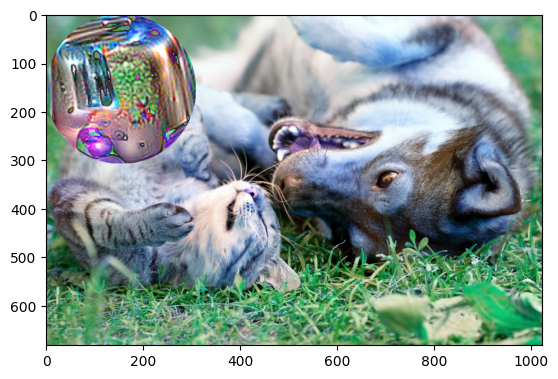

In [36]:
img1 = cv2.imread('/home/minhyeok/Data/catndog.jpg', cv2.IMREAD_COLOR)
img2 = cv2.imread('/home/minhyeok/Data/adversarial patch (toaster).png', cv2.IMREAD_COLOR)


# 이미지의 높이, 너비, 채널 수 구하기
height, width, channels = img2.shape
# 배경 이미지의 ROI(Region of Interest : 관심영역) 구하기
roi = img1[0:height, 0:width]

dst = np.where(img2>10, img2, roi)
# 배경 이미지의 ROI 영역을 위의 dst 이미지로 변경
img1[0:height, 0:width] = dst

plt.imshow(img1)

### Vit model load


In [2]:
# timm model list
model_names = timm.list_models(pretrained=True)

In [3]:
# Vit model load
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

model = timm.create_model('vit_base_patch16_224', pretrained=True)

config = resolve_data_config({}, model=model)
transform = create_transform(**config)

model = model.eval()

In [4]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2022-11-29 17:10:59--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.26.46, 52.217.225.216, 52.216.245.134, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.26.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/home/minhyeok/.torch/models/imagenet_class_index.json.5’

imagenet_class_inde 100%[===================>]  34.53K   174KB/s    in 0.2s    

2022-11-29 17:11:00 (174 KB/s) - ‘/home/minhyeok/.torch/models/imagenet_class_index.json.5’ saved [35363/35363]



In [5]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [6]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

#### Image load

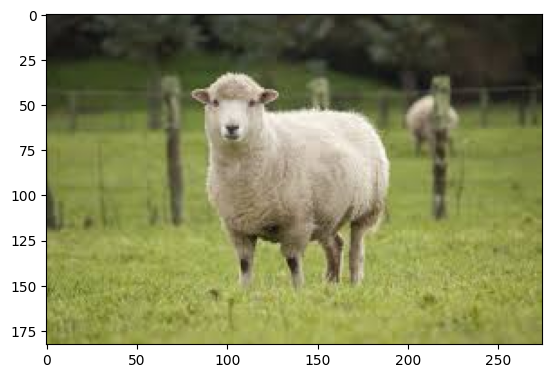

In [7]:
# img = Image.open('/home/minhyeok/Data/catndog.jpg')
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTN1tl8wwiWUOYKIjZF7RYeVYT7aixcJxGAoQ&usqp=CAU"
image = Image.open(requests.get(url, stream=True).raw)

transformed_img = transform(image)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0) # 1,3,224,224

plt.imshow(image)
plt.show()


In [8]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


Predicted: ram ( 0.2830289900302887 )


In [9]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

Predicted: ram ( 0.2830289900302887 )


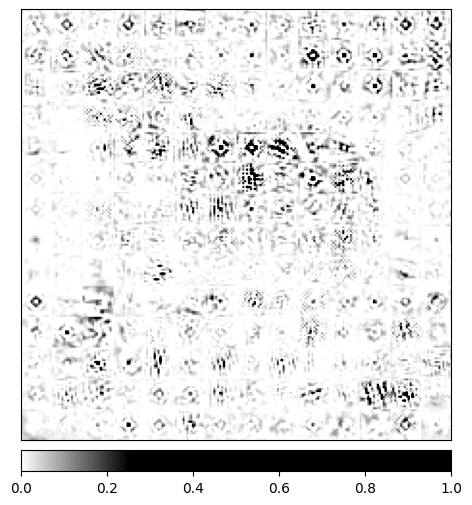

In [10]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

#### Noise tunnel

Let us compute attributions using Integrated Gradients and smoothens them across multiple images generated by a noise tunnel. The latter adds gaussian noise with a std equals to one, 10 times (nt_samples=10) to the input. Ultimately, noise tunnel smoothens the attributions across nt_samples noisy samples using smoothgrad_sq technique. smoothgrad_sq represents the mean of the squared attributions across nt_samples samples.

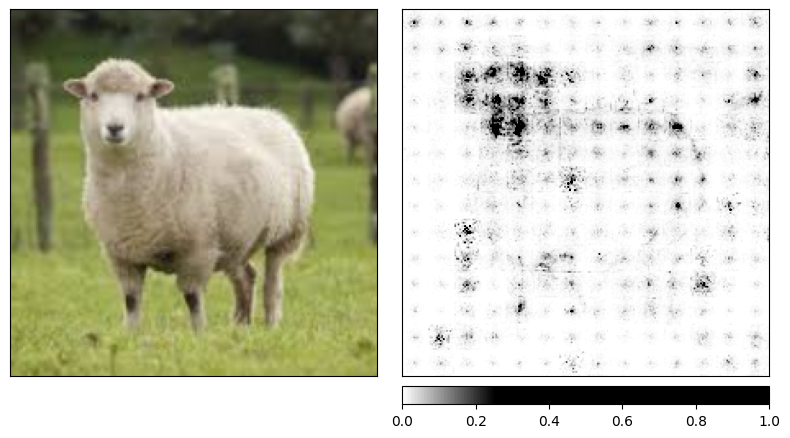

In [11]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

#### Gradient shap

Finally, let us use GradientShap, a linear explanation model which uses a distribution of reference samples (in this case two images) to explain predictions of the model. It computes the expectation of gradients for an input which was chosen randomly between the input and a baseline. The baseline is also chosen randomly from given baseline distribution.

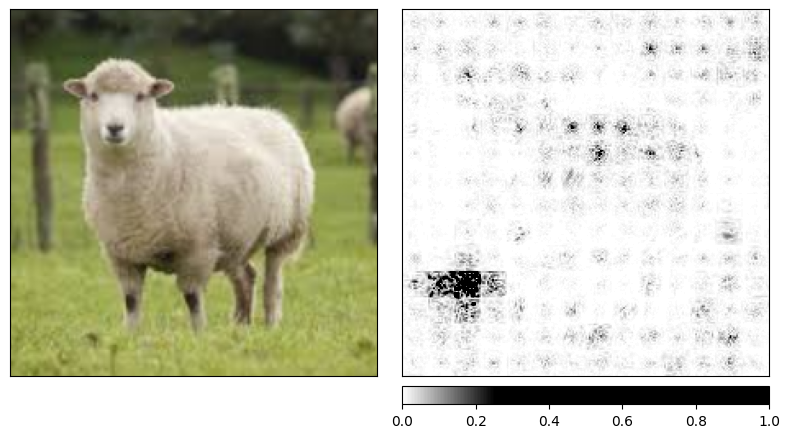

In [12]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

#### occulusion

Now let us try a different approach to attribution. We can estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes.

We run a sliding window of size 15x15 (defined via sliding_window_shapes) with a stride of 8 along both image dimensions (a defined via strides). At each location, we occlude the image with a baseline value of 0 which correspondes to a gray patch (defined via baselines).

In [13]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

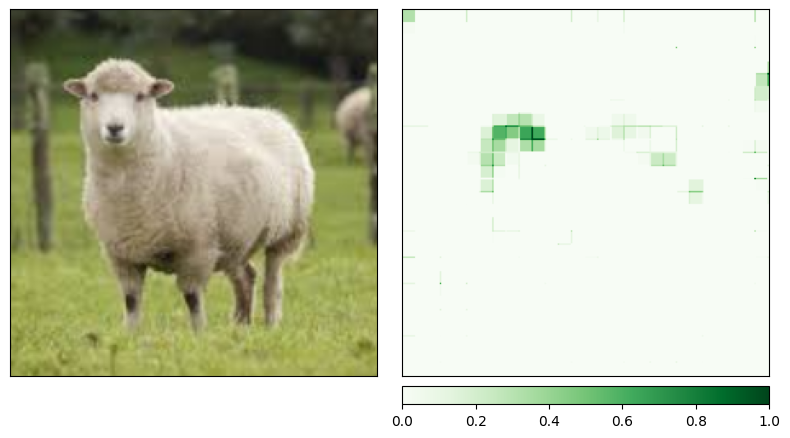

In [14]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

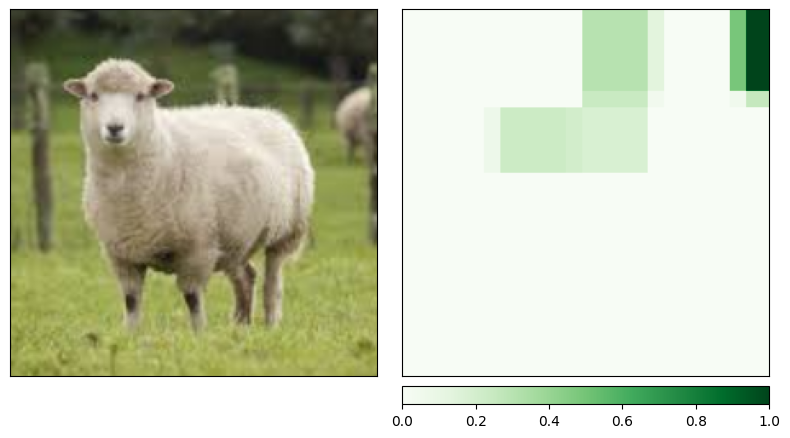

In [15]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

### CNN (resnet50 model prediction)

torch.Size([1, 3, 224, 224])


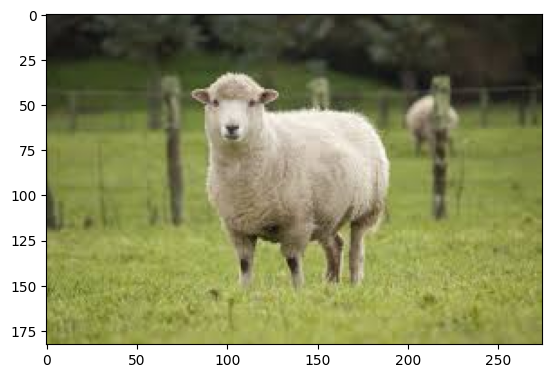

In [36]:
# url = "https://www.akc.org/wp-content/uploads/2015/06/Golden-Retriever-laying-down-playing-with-a-cat.jpeg"
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTN1tl8wwiWUOYKIjZF7RYeVYT7aixcJxGAoQ&usqp=CAU"
image = Image.open(requests.get(url, stream=True).raw)
transformed_img = transform(image)
input = transform_normalize(transformed_img)
input = input.unsqueeze(0)
print(input.size())



In [37]:
model = models.resnet50(pretrained=True)
model = model.eval()

/home/minhyeok/anaconda3/envs/cmh_j/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/minhyeok/anaconda3/envs/cmh_j/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


Predicted: ram ( 0.7947633266448975 )


In [39]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

Predicted: ram ( 0.7947633266448975 )


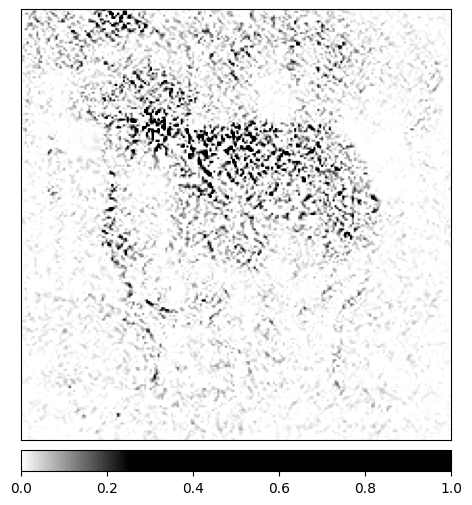

In [40]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

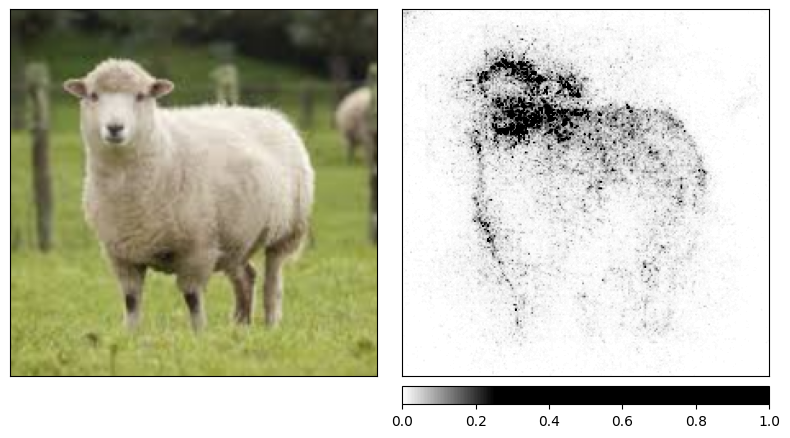

In [41]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

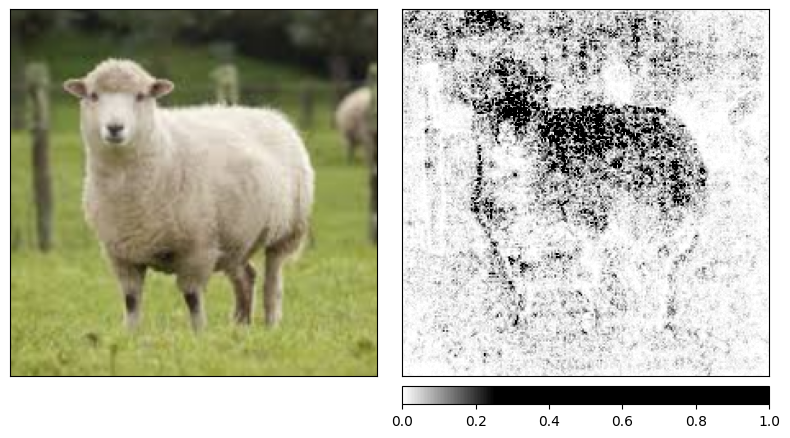

In [42]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [43]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

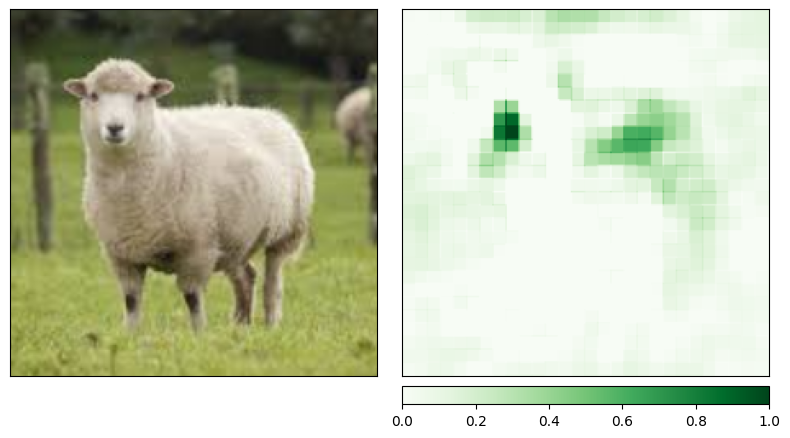

In [44]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

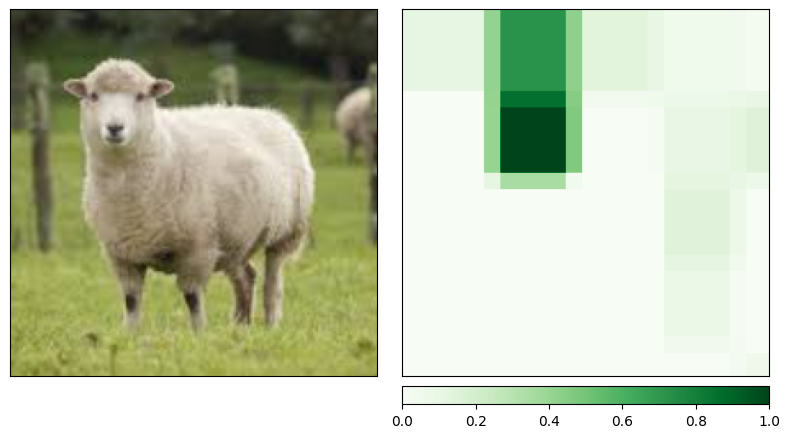

In [45]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )